# Main Fig

## Normal Mode

In [1]:
import numpy as np
import pandas as pd
from numpy import savetxt
import time
import tracemalloc
tracemalloc.start()
start_time = time.time()

def Disorder_mat(W):
    return np.random.uniform(-W/2, W/2, size = N*Lx).reshape((Lx, L, L))

def M_tr_x(x):
    H = np.zeros((N,N))
    for i in range(0,L):
        for j in range(0,L):
            H[i*L+j, i*L+j         ] = Disorder[x, j, i] - E
            H[i*L+j, i*L + (j-1)%L ] = V
            H[i*L+j, i*L + (j+1)%L ] = V
            H[i*L+j, (i-1)%L*L + j ] = V
            H[i*L+j, (i+1)%L*L + j  ] = V   
    M1 = np.hstack((H, Identity_mat))
    M2 = np.hstack((-Identity_mat, Zero_mat))
    M_x = np.vstack((M1, M2))
    return M_x

def R_mtr_x(q):
    l = int(Lx/q)
    Q_inter = np.identity(2*N)
    for j in range(1, int(l + 1)):
        Eq_lef = np.identity(2*N)
        for k in range(j*q+1-q-1, j*q):
            Eq_lef = np.dot( M_tr_x(k), Eq_lef)# Method 
        Eq_lef = np.dot(Eq_lef, Q_inter) 
        Q_mtr, R_mtr = np.linalg.qr(Eq_lef)
        Q_inter = Q_mtr
        yield R_mtr[N-1, N-1]

def D_k_N(k):
    sum = 0
    for j in range(k*r-r+1, k*r+1):
        sum += (1.0/p)*np.log(np.abs( next( R_N ) )) # Method 3 Use yield
    return sum

def Gamma_N_ad(q):
    sum = 0
    s = int(Lx/p)
    sum_sq = 0
    for k_index in range(1,s+1):
        D_kN = D_k_N(k_index)
        sum += D_kN/s
        sum_sq += D_kN**2/s
    return sum, sum_sq

L = 4
Lx = 60
N = L**2
Identity_mat = np.identity(N)
Zero_mat = np.zeros((N, N))

V = 1
E = 1

q = 6
r = 5
p = q*r
s = int(Lx/q)

W_index = np.linspace(15.0, 18.0, 31)
box = []
err = []

for W in W_index:
    Disorder = Disorder_mat(W)
    R_N = R_mtr_x(q) # Use yield
    gamma_bar, gamma_sq_bar = Gamma_N_ad(q)
    gamma_err = np.sqrt( np.abs( (gamma_sq_bar - gamma_bar**2)/(s-1) ) )
    box.append( L*np.abs(gamma_bar) )
    err.append( L*gamma_err )
    
end_time = time.time()
print(end_time - start_time,'s')

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
tracemalloc.stop()
savetxt('box_L-Num.csv', box, delimiter=',')

0.22693395614624023 s
Current memory usage is 0.056826MB; Peak was 0.084896MB


## Use Sparse Matrix

In [25]:
import numpy as np
import pandas as pd
from numpy import savetxt
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import dia_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy import linalg


import time
import tracemalloc
tracemalloc.start()
start_time = time.time()

def Disorder_mat(W):
    return np.random.uniform(-W/2, W/2, size = N*Lx).reshape((Lx, L, L))

def M_tr_x(x):
    H = lil_matrix((N,N))
    for i in range(0,L):
        for j in range(0,L):
            H[i*L+j, i*L+j         ] = Disorder[x, j, i] - E
            H[i*L+j, i*L + (j-1)%L ] = V
            H[i*L+j, i*L + (j+1)%L ] = V
            H[i*L+j, (i-1)%L*L + j ] = V
            H[i*L+j, (i+1)%L*L + j  ] = V   
    H = H.tocsr()
    M1 = hstack([H, id_sp])
    M2 = hstack([id_sp_minu, ze_sp])
    M_x = vstack([M1, M2])    
    return M_x

def R_mtr_x(q):
    l = int(Lx/q)
    Q_inter = Id_sp

    for j in range(1, int(l + 1)):
        Eq_lef = Id_sp
        for k in range(j*q+1-q-1, j*q): 
            Eq_lef = M_tr_x(k)@Eq_lef # Use sparse here
            
        Eq_lef = Eq_lef@Q_inter # Sparse
        
        Eq_lef = Eq_lef.todense()
        #print('Dense:', Eq_lef)
        Q_mtr, R_mtr = linalg.qr(Eq_lef) # Sparse
        #Q_mtr, R_mtr = np.linalg.qr(Eq_lef)
        
        #Q_inter = Q_mtr
        Q_inter = csr_matrix(Q_mtr) # Sparse
        yield R_mtr[N-1, N-1]

def D_k_N(k):
    sum = 0
    for j in range(k*r-r+1, k*r+1):
        sum += (1.0/p)*np.log(np.abs( next( R_N ) )) # Method 3 Use yield
    return sum

def Gamma_N_ad(q):
    sum = 0
    s = int(Lx/p)
    sum_sq = 0
    for k_index in range(1,s+1):
        D_kN = D_k_N(k_index)
        sum += D_kN/s
        sum_sq += D_kN**2/s
    return sum, sum_sq

L = 4
Lx = 60
N = L**2
Identity_mat = np.identity(N)
Zero_mat = np.zeros((N, N))

id_sp = csr_matrix(Identity_mat)
id_sp_minu = csr_matrix(-Identity_mat)
ze_sp = csr_matrix(Zero_mat)
Id_sp = csr_matrix(np.identity(2*N))

#id_sp = lil_matrix(Identity_mat)
#id_sp_minu = lil_matrix(-Identity_mat)
#ze_sp = lil_matrix(Zero_mat)
#Id_sp = lil_matrix(np.identity(2*N))

#id_sp = dia_matrix(Identity_mat)
#id_sp_minu = dia_matrix(-Identity_mat)
#ze_sp = dia_matrix(Zero_mat)
#Id_sp = dia_matrix(np.identity(2*N))

V = 1
E = 1

q = 6
r = 5
p = q*r
s = int(Lx/q)

W_index = np.linspace(15.0, 18.0, 31)
box = []
err = []

for W in W_index:
    Disorder = Disorder_mat(W)
    R_N = R_mtr_x(q) # Use yield
    gamma_bar, gamma_sq_bar = Gamma_N_ad(q)
    gamma_err = np.sqrt( np.abs( (gamma_sq_bar - gamma_bar**2)/(s-1) ) )
    box.append( L*np.abs(gamma_bar) )
    err.append( L*gamma_err )
    
end_time = time.time()
print(end_time - start_time,'s')

current, peak = tracemalloc.get_traced_memory()
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
tracemalloc.stop()
savetxt('box_L-Num.csv', box, delimiter=',')

11.303283452987671 s
Current memory usage is 1.706158MB; Peak was 3.463669MB


# FSS Fit

## Use scipy.optimize

<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
C:\Users\67355\AppData\Local\Temp\ipykernel_19688\747185827.py:71: SyntaxWarning: invalid escape sequence '\s'
  print('av \sigma = ', sigma_av)
C:\Users\67355\AppData\Local\Temp\ipykernel_19688\747185827.py:45: RuntimeWarning: overflow encountered in scalar power
  phi_2 = (L**alpha_2)*( b_20 + b_21*w + b_22*w*w)
C:\Users\67355\AppData\Local\Temp\ipykernel_19688\747185827.py:47: RuntimeWarning: invalid value encountered in add
  + 1*phi_2 + a_11*phi_1*phi_2 + a_21*(phi_1**2)*phi_2 + a_31*(phi_1**3)*phi_2
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


L = 4
sigma =  0.0007387699577182378
av \sigma =  0.0004352808076887207
$\nu = $ 1.5727323043468278 

L = 6
sigma =  0.0009169362527479983
av \sigma =  0.0005363827823718737
$\nu = $ 1.5875198517966247 

L = 8
sigma =  0.0010618838387713775
av \sigma =  0.0006211775850233011
$\nu = $ 1.5792366183674247 

L = 10
sigma =  0.002056688211804086
av \sigma =  0.0012053651985941625
$\nu = $ 1.5859125299862094 

L = 12
sigma =  0.0025209598262530527
av \sigma =  0.001480406415890144
$\nu = $ 1.5870879546161445 

L = 16
sigma =  0.0058157604741830736
av \sigma =  0.0034223314789790745
$\nu = $ 1.587292316830328 

L = 20
sigma =  0.011856569838357343
av \sigma =  0.007024434731648817
$\nu = $ 1.5876312136697903 

$<\nu> = $ 1.583916112801907
$std \ \nu$ 0.005334646388504621
$<W_c> = $ 16.528743845777974


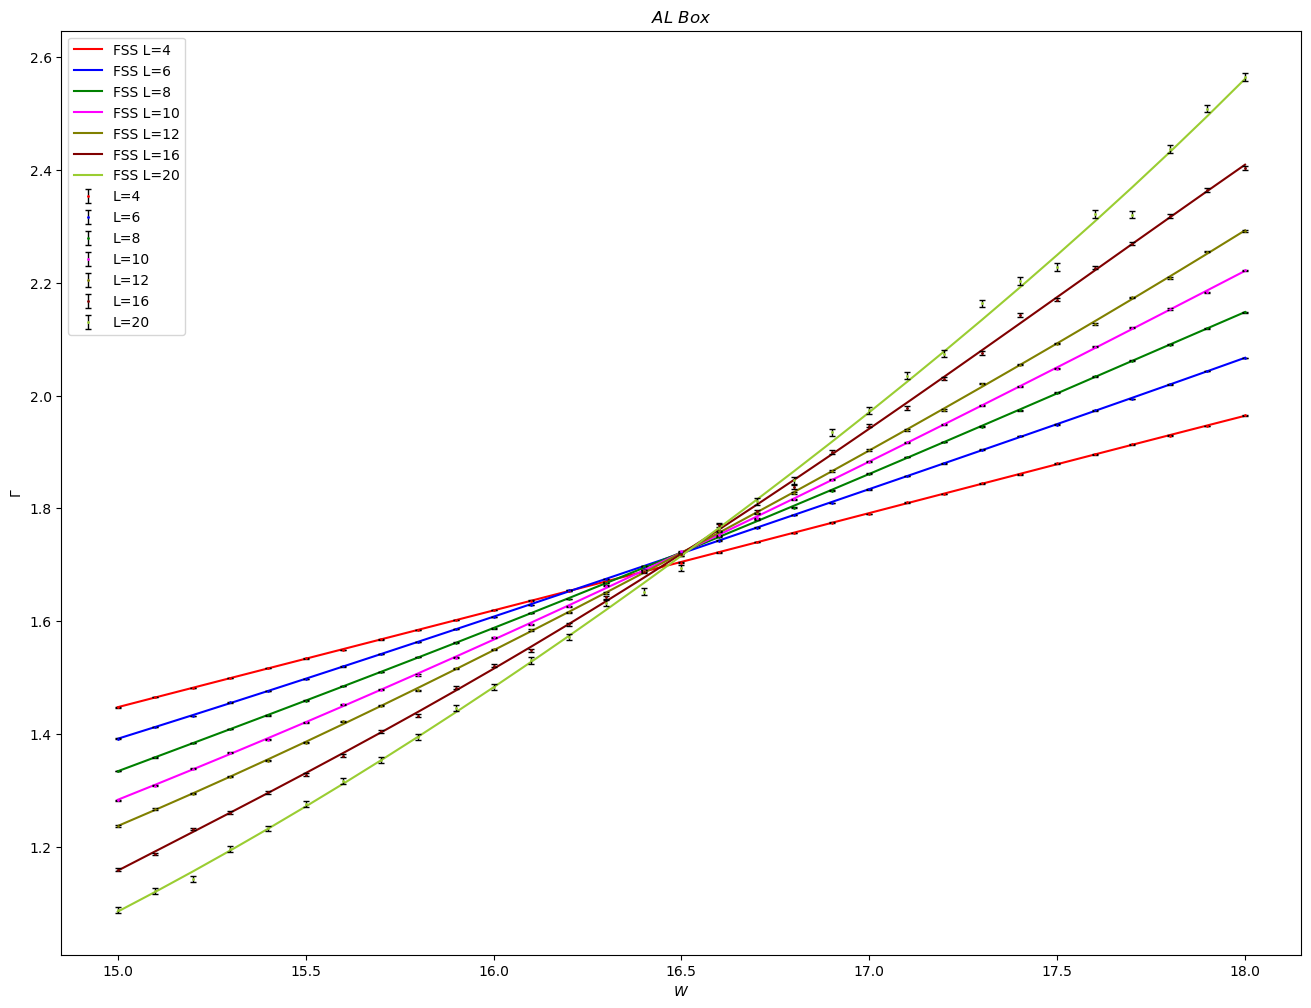

In [5]:
import numpy as np
from scipy import optimize as op
import pandas as pd
from numpy import savetxt
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline

box4 = loadtxt('box_L-4.csv', delimiter=',')
box4_err = loadtxt('box_L-4-err.csv', delimiter=',')

box6 = loadtxt('box_L-6.csv', delimiter=',')
box6_err = loadtxt('box_L-6-err.csv', delimiter=',')

box8 = loadtxt('box_L-8.csv', delimiter=',')
box8_err = loadtxt('box_L-8-err.csv', delimiter=',')

box10 = loadtxt('box_L-10.csv', delimiter=',')
box10_err = loadtxt('box_L-10-err.csv', delimiter=',')

box12 = loadtxt('box_L-12.csv', delimiter=',')
box12_err = loadtxt('box_L-12-err.csv', delimiter=',')

box16 = loadtxt('box_L-16.csv', delimiter=',')
box16_err = loadtxt('box_L-16-err.csv', delimiter=',')

box20 = loadtxt('box_L-20.csv', delimiter=',')
box20_err = loadtxt('box_L-20-err.csv', delimiter=',')

#box24 = loadtxt('box_L-24.csv', delimiter=',')
#box24_err = loadtxt('box_L-24-err.csv', delimiter=',')

data_AL = [box4, box6, box8, box10, box12, box16, box20]#, box24]
data_AL_err = [box4_err, box6_err, box8_err, box10_err, box12_err, box16_err, box20_err]#, box24_err]

color = ['red', 'blue', 'green', 'magenta', 'olive', 'maroon', 'yellowgreen', 'aqua']  
label_scatter = ['L=4', 'L=6', 'L=8', 'L=10', 'L=12', 'L=16', 'L=20', 'L=24']
label_fit = ['FSS L=4', 'FSS L=6', 'FSS L=8', 'FSS L=10', 'FSS L=12', 'FSS L=16', 'FSS L=20', 'FSS L=24']
L_index = [4, 6, 8, 10, 12, 16, 20, 24]

def F(W, W_c, alpha_1, alpha_2, a_00, a_11, a_20, a_21, a_30, a_31, b_11, b_12, b_20, b_21, b_22):
    w = W/W_c - 1.
    #phi_1 = (L**alpha_1)*( b_10 + b_11*w + b_12*w*w)
    phi_1 = (L**alpha_1)*( b_11*w + b_12*w*w)
    phi_2 = (L**alpha_2)*( b_20 + b_21*w + b_22*w*w)
    F_fit = a_00 + 1*phi_1 + a_20*phi_1**2 + a_30*phi_1**3 
    + 1*phi_2 + a_11*phi_1*phi_2 + a_21*(phi_1**2)*phi_2 + a_31*(phi_1**3)*phi_2
    return F_fit
    
para_initial = [16.53, 0.63, -2.5, 1., 1., 1., 1., 1., 1., 1.3, 1., -0.3, 1., 1.]
bound_initial =([16., 0.10, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf], [17., 1.0, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

nu = []
W_cri = []
plt.figure(figsize=(16,12))
for i in range(len(data_AL)):
    #if i!=0:
    if True:
        L = L_index[i]
        #popt, pcov= op.curve_fit(F, W_index, data_AL[i], p0=para_initial, maxfev = 50000)
        popt, pcov= op.curve_fit(F, W_index, data_AL[i], p0=para_initial, bounds = bound_initial, method='trf')#, gtol=1e-36)
        y_new = F(W_index, *popt)
        plt.plot(W_index, y_new, color = color[i], label = label_fit[i])
        plt.errorbar(W_index, data_AL[i], yerr=data_AL_err[i], fmt='o', ecolor='black', color=color[i], ms=1, elinewidth=1, capsize=2, label=label_scatter[i])
        nu.append(1/popt[1])
        W_cri.append(popt[0])
        sigma_av = 2*np.mean(data_AL_err[i]/data_AL[i])
        sigma = 2*np.mean(data_AL_err[i])
        print('L =',L)
        print('sigma = ', sigma)
        print('av \sigma = ', sigma_av)
        print(r'$\nu = $', 1/popt[1],'\n')
        #print(popt,'\n')

print(r'$<\nu> = $', sum(nu)/len(nu))
print(r'$std \ \nu$', np.std(nu))
print(r'$<W_c> = $', sum(W_cri)/len(W_cri))
plt.xlabel(r'$W$')
plt.ylabel(r'$\Gamma$')
plt.title(r'$AL \ Box$')
plt.legend()
#plt.grid()
plt.savefig('AL_Box.eps', dpi=600, format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


$<\nu> = $ 1.5847682096214897
$std \ \nu$ 0.004044519221485572
$<W_c> = $ 16.52742932309404


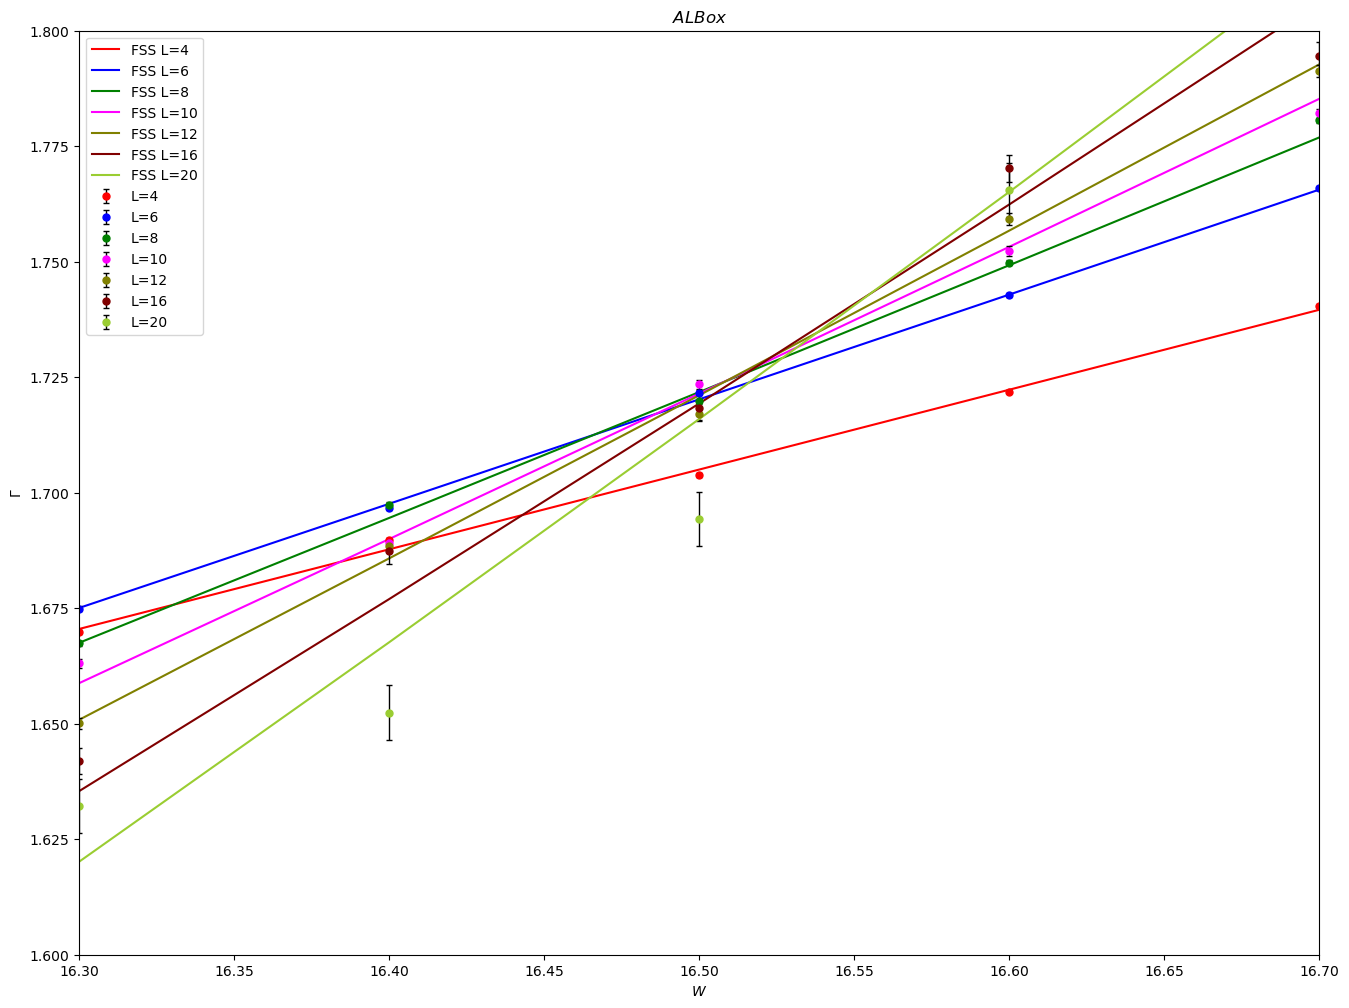

In [6]:
import numpy as np
from scipy import optimize as op
import pandas as pd
from numpy import savetxt
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline

box4 = loadtxt('box_L-4.csv', delimiter=',')
box4_err = loadtxt('box_L-4-err.csv', delimiter=',')

box6 = loadtxt('box_L-6.csv', delimiter=',')
box6_err = loadtxt('box_L-6-err.csv', delimiter=',')

box8 = loadtxt('box_L-8.csv', delimiter=',')
box8_err = loadtxt('box_L-8-err.csv', delimiter=',')

box10 = loadtxt('box_L-10.csv', delimiter=',')
box10_err = loadtxt('box_L-10-err.csv', delimiter=',')

box12 = loadtxt('box_L-12.csv', delimiter=',')
box12_err = loadtxt('box_L-12-err.csv', delimiter=',')

box16 = loadtxt('box_L-16.csv', delimiter=',')
box16_err = loadtxt('box_L-16-err.csv', delimiter=',')

box20 = loadtxt('box_L-20.csv', delimiter=',')
box20_err = loadtxt('box_L-20-err.csv', delimiter=',')

#box24 = loadtxt('box_L-24.csv', delimiter=',')
#box24_err = loadtxt('box_L-24-err.csv', delimiter=',')

data_AL = [box4, box6, box8, box10, box12, box16, box20]#, box24]
data_AL_err = [box4_err, box6_err, box8_err, box10_err, box12_err, box16_err, box20_err]#, box24_err]

color = ['red', 'blue', 'green', 'magenta', 'olive', 'maroon', 'yellowgreen', 'aqua']  
label_scatter = ['L=4', 'L=6', 'L=8', 'L=10', 'L=12', 'L=16', 'L=20', 'L=24']
label_fit = ['FSS L=4', 'FSS L=6', 'FSS L=8', 'FSS L=10', 'FSS L=12', 'FSS L=16', 'FSS L=20', 'FSS L=24']
L_index = [4, 6, 8, 10, 12, 16, 20, 24]

def F(W, W_c, alpha_1, alpha_2, a_00, a_11, a_20, a_21, a_30, a_31, b_11, b_12, b_20, b_21, b_22):
    w = W/W_c - 1.
    #phi_1 = (L**alpha_1)*( b_10 + b_11*w + b_12*w*w)
    phi_1 = (L**alpha_1)*( b_11*w + b_12*w*w)
    phi_2 = (L**alpha_2)*( b_20 + b_21*w + b_22*w*w)
    F_fit = a_00 + 1*phi_1 + a_20*phi_1**2 + a_30*phi_1**3 
    + 1*phi_2 + a_11*phi_1*phi_2 + a_21*(phi_1**2)*phi_2 + a_31*(phi_1**3)*phi_2
    return F_fit
    
para_initial = [16.53, 0.63, -2.5, 1., 1., 1., 1., 1., 1., 1.3, 1., -0.3, 1., 1.]
bound_initial =([16., 0.20, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf], [17., 0.90, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

nu = []
W_cri = []
plt.figure(figsize=(16,12))
for i in range(len(data_AL)):
    #if i!=0:
    if True:
        L = L_index[i]
        #popt, pcov= op.curve_fit(F, W_index, data_AL[i], p0=para_initial, maxfev = 50000)
        popt, pcov= op.curve_fit(F, W_index, data_AL[i], p0=para_initial, bounds = bound_initial, method='trf')#, gtol=1e-36)
        y_new = F(W_index, *popt)
        plt.plot(W_index, y_new, color = color[i], label = label_fit[i])
        plt.errorbar(W_index, data_AL[i], yerr=data_AL_err[i], fmt='o', ecolor='black', color=color[i], ms=5, elinewidth=1, capsize=2, label=label_scatter[i])
        nu.append(1/popt[1])
        W_cri.append(popt[0])
        sigma_av = 2*np.mean(data_AL_err[i]/data_AL[i])
        sigam = 2*np.mean(data_AL_err[i])
        #print('L =',L)
        #print('sigma = ', sigma)
        #print('av \sigma = ', sigma_av)
        #print(r'$\nu = $', 1/popt[1])
        #print(popt,'\n')

print(r'$<\nu> = $', np.mean(nu))
print(r'$std \ \nu$', np.std(nu))
print(r'$<W_c> = $', np.mean(W_cri))
plt.xlabel(r'$W$')
plt.ylabel(r'$\Gamma$')
plt.title(r'$AL Box$')
plt.legend()
plt.xlim(16.3,16.7)
plt.ylim(1.6,1.8)
#plt.grid()
plt.savefig('AL_Box_Near_Critical.eps',dpi=600, format='eps')
plt.show()

# For fig 1

In [4]:
import numpy as np
import pandas as pd
from numpy import savetxt
#import tracemalloc
import time

start_time = time.time()
#tracemalloc.start()

def Disorder_mat(W):
    return np.random.uniform(-W/2, W/2, size = Ly*Lz*Lx).reshape((Lx, Ly, Lz))

def M_tr_x(x):
    H = np.zeros((N,N))
    for i in range(0,L):
        for j in range(0,L):
            H[i*L+j, i*L+j         ] = Disorder[x, j, i] - E
            H[i*L+j, i*L + (j-1)%L ] = V
            H[i*L+j, i*L + (j+1)%L ] = V
            H[i*L+j, (i-1)%L*L + j ] = V
            H[i*L+j, (i+1)%L*L + j  ] = V   
    M1 = np.hstack((H, Identity_mat))
    M2 = np.hstack((-Identity_mat, Zero_mat))
    M_x = np.vstack((M1, M2))
    return M_x

def R_mtr_x(q):
    l = int(Lx/q)
    Q = []
    R = []
    Q_0 = np.identity(2*Ly*Lz)
    Q.append(Q_0)
    R.append(np.identity(2*Ly*Lz))
    for j in range(1, int(l + 1)):
        Eq_lef = np.identity(2*Ly*Lz)
        for k in range(j*q+1-q-1, j*q):
            #Eq_lef = np.dot( M_mat_sum[k], Eq_lef)# Method 1, use M_mat_sum
            Eq_lef = np.dot( M_tr_x(k), Eq_lef)# Method 2
        Eq_lef = np.dot(Eq_lef, Q[j-1])
        Q_mtr, R_mtr = np.linalg.qr(Eq_lef)
        Q.append(Q_mtr)
        R.append(R_mtr)
    return R

'''
def Gamma_N(q):
    l = int(Lx/q)
    sum = 0.
    for i in range(1, l+1):
        R_j = R_mtr_x(q)[i]
        sum += np.log(np.abs(R_j[N-1, N-1]))
    gamma_N = sum/Lx
    return gamma_N
'''

def D_k_N(k):
    sum = 0
    for j in range(k*r-r+1, k*r+1):
        #R_N = R_mat_sum[j]
        #sum += (1.0/p)*np.log(np.abs(R_N[N-1,N-1])) # Method 1

        sum += (1.0/p)*np.log( np.abs( R_mat_sum[j][N-1,N-1] ) ) # Method 2
        
        #R_N = R_mtr_x(q)[j]
        #sum = sum + (1.0/p)*np.log(np.abs(R_N[N-1,N-1])) # Method 3
    return sum

def Gamma_N_ad(q):
    sum = 0
    s = int(Lx/p)
    for k_index in range(1,s+1):
        sum += (1.0/s)*D_k_N(k_index)
    return sum

L = 4
Ly = L
Lz = L
Lx = 120
N = Ly*Lz
Identity_mat = np.identity(Ly*Lz)
Zero_mat = np.zeros((Ly*Lz, Ly*Lz))

V = 1
E = 1

q = 6
r = 5
p = q*r

W_index = [15]
box = []

for index_ in range(100):
    for W in W_index:
        Disorder = Disorder_mat(W)
        
        #M_mat_sum = []
        #for i in range(Lx):
        #    M_mat_sum.append( M_tr_x(i) )
        #current, peak = tracemalloc.get_traced_memory()
        #print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        
        R_mat_sum = R_mtr_x(q) # Method 1&2
        
        box.append( np.abs( L*Gamma_N_ad(q) ) )


end_time = time.time()
print(end_time - start_time,'s')
#tracemalloc.stop()
savetxt('box_distribution_fig1.csv', box, delimiter=',')

0.5965416431427002 s


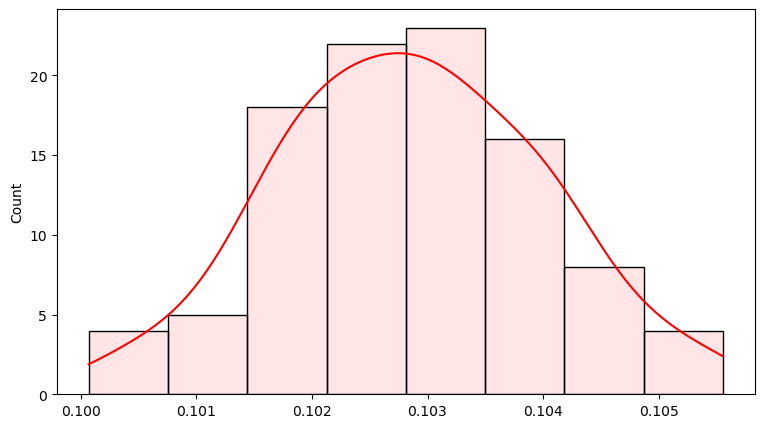

Mean =  0.10285223482348427
Std Error =  0.0011396101353383886
Var Error =  1.2987112605659806e-06
Fluctation =  1.108007169016984 %


In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
from numpy import savetxt
from numpy import loadtxt
#import tracemalloc
#import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

data_box_distribution = loadtxt('box_L-dis.csv', delimiter=',') # Lx = 10^5
data_box_distribution = data_box_distribution

sns.set_palette("hls")
mpl.rc("figure", figsize=(9,5))
sns.histplot(data_box_distribution, alpha=0.1, color='red', kde=True)
#plt.savefig('Fluctation.eps', dpi=600, format='eps')
plt.savefig('Fluctation.png')
plt.show()

mean = np.mean(data_box_distribution)
std_err = np.std(data_box_distribution)
var_err = np.var(data_box_distribution)

print('Mean = ', mean)
print('Std Error = ', std_err)
print('Var Error = ', var_err)
print('Fluctation = ', 100*std_err/mean,'%')